In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
import time
import json

In [86]:
import pulp
#solver_list = pulp.listSolvers(onlyAvailable=True)
#print(solver_list)
#['CPLEX_PY', 'PULP_CBC_CMD']

In [87]:
result_log = {'method':'tsp',
              'case':f'run_{int(time.time())}'}
result_log

{'method': 'tsp', 'case': 'run_1724323083'}

In [88]:
length_x = 1
length_y = 1

In [89]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [90]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [91]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [92]:
max_wave = 3
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [93]:
result_log['wave_numbers']=wave_numbers

In [94]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [95]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [96]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [97]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

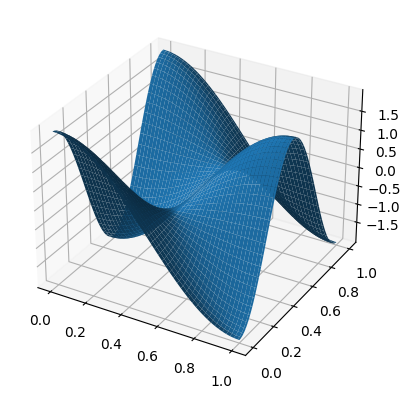

In [98]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,2)])

In [99]:
my_mean = np.array([0.5,0.5])
my_cov = np.array([[0.01,0.02],[-0.04,0.08]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [100]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij
result_log['pdf']='gaussian'

In [101]:
# optional overwrite with uniform
#my_pdf = np.ones_like(x_grid)/(length_x*length_y)
#result_log['pdf']='uniform'

In [102]:
# uniform in a subset
#my_pdf = (x_grid**2 + y_grid**2 >= 0.6)
#result_log['pdf']='uniform-hole'

In [103]:
my_pdf = my_pdf/inner_product(my_pdf,basis[(0,0)])

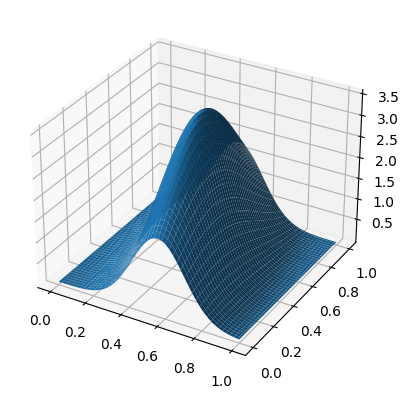

In [104]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [105]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [106]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

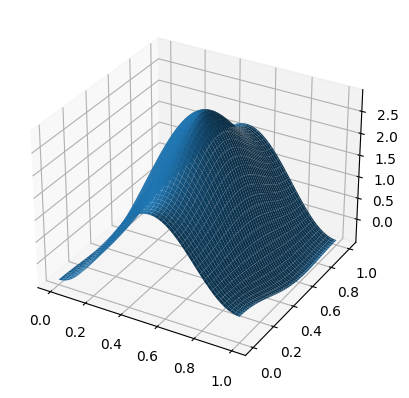

In [107]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [108]:
wp_num_x = 6
wp_num_y = 6

In [109]:
# square mesh
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))
result_log['mesh'] = f'square {wp_num_x}x{wp_num_y}'

In [110]:
# convert to triangular mesh
#x_wp[1::2,:] = x_wp[1::2,:] + 0.5*length_x/(wp_num_x-1)
#x_wp = x_wp*(wp_num_x-1)/(wp_num_x-0.5)
#y_wp = y_wp*np.cos(np.pi/6.0)*(wp_num_x-1)/(wp_num_x-0.5)
#y_wp = y_wp + 0.5*length_y-np.median(y_wp,axis=None)
#result_log['mesh'] = f'tri {wp_num_x}x{wp_num_y}'

In [111]:
num_wp = wp_num_x*wp_num_y

In [112]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

In [113]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]

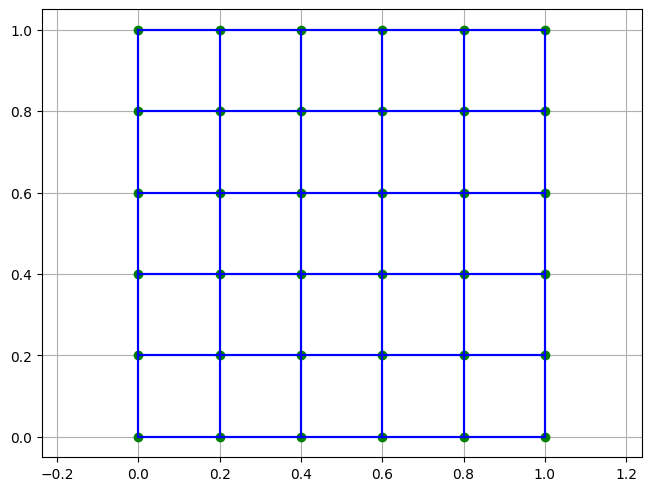

In [114]:
fig,ax = plt.subplots(layout='constrained')
ax.plot(x_wp,y_wp,'go')
for (i,j) in links:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'b-')
ax.axis('equal')
ax.grid('on')

In [115]:
# add a magic node for start and finish
links += [('magic',i) for i in range(num_wp)]
links += [(i,'magic') for i in range(num_wp)]

In [116]:
wp_list = ['magic'] + [i for i in range(num_wp)]

In [117]:
prob = pulp.LpProblem('ergo')

In [118]:
x = pulp.LpVariable.dicts("x",links,0,1,pulp.LpInteger)
num_binaries = len(x)
print(f'There are {num_binaries} binary x variables')
result_log['num_binaries'] = num_binaries

There are 192 binary x variables


In [119]:
# continuity - must leave everywhere we go
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) == sum(sum([x[i,j] for (i,j) in links if j==w])))

In [120]:
# can't go anywhere twice - would be nice to omit this, but then how to include subtours?
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) <= 1)

In [121]:
v = pulp.LpVariable.dicts("v",wp_list,0,num_wp,pulp.LpContinuous)

In [122]:
# subtour elimination by MTZ
for (i,j) in links:
    if j!='magic':
        prob.addConstraint(v[j]>=v[i]+1-num_wp*(1-x[i,j]))

In [123]:
num_moves = wp_num_x + wp_num_y
num_moves = wp_num_x + wp_num_y + 2
num_moves
result_log['num_moves']=num_moves

In [124]:
prob.addConstraint(sum([x[lk] for lk in links])==num_moves)

In [125]:
f_traj = {}
for (i,j) in links:
    if i!='magic' and j!='magic':
        sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
        for k in wave_numbers:
            f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [126]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [127]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [128]:
for k in wave_numbers:
    prob.addConstraint(s[k] >= (eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!='magic' and j!='magic'])/num_moves))
    prob.addConstraint(s[k] >= -(eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!='magic' and j!='magic'])/num_moves))

In [129]:
prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]))

In [130]:
time_limit = 300
result_log['time_limit']=time_limit
#prob.solve(solver=pulp.CPLEX_PY(timeLimit=time_limit))
prob.solve()
print(pulp.LpStatus[prob.status])

Optimal


In [131]:
result_log['solve_time'] = prob.solutionTime
result_log['objective'] = prob.objective.value()

In [132]:
result_log['ergodic'] = sum([lam[k]*(eta[k] - sum([f_traj[i,j,k]*x[i,j].value() for (i,j) in links if i!='magic' and j!='magic'])/(num_moves-2))**2 for k in wave_numbers])

In [133]:
moves = [(i,j) for (i,j) in links if x[i,j].value()>=0.5]
moves

[(8, 9),
 (9, 10),
 (10, 4),
 (14, 8),
 (15, 14),
 (19, 20),
 (20, 21),
 (21, 15),
 (25, 19),
 (26, 25),
 (27, 26),
 (28, 27),
 ('magic', 28),
 (4, 'magic')]

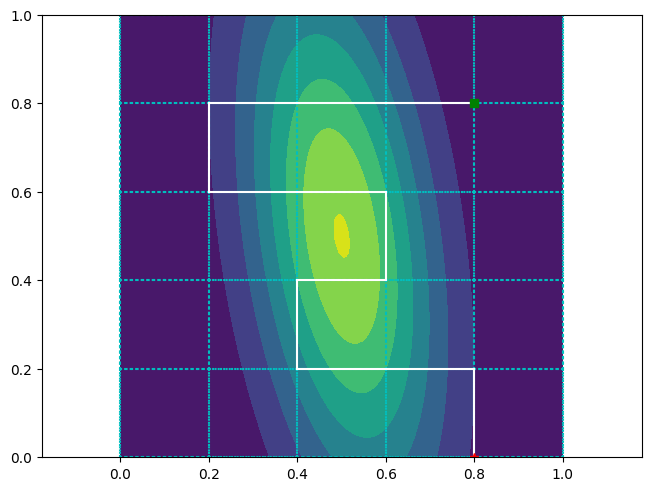

In [135]:
fig,ax = plt.subplots(layout='constrained')
ax.contourf(x_grid,y_grid,my_pdf)
#ax.plot(x_wp,y_wp,'y+')
for (i,j) in links:
    if i!='magic' and j!='magic':
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'c:')
for (i,j) in moves:
    if i=='magic':
        plt.plot(wp_array[0,j],wp_array[1,j],'gs')
    elif j=='magic':
        plt.plot(wp_array[0,i],wp_array[1,i],'r*')
    else:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'w-')
ax.axis('equal')
plt.savefig(result_log['case'])
with open(result_log['case']+'.json', 'w') as f:
    json.dump(result_log,f)